In [3]:
import dash
from dash import dash_table, dcc, html
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from dash.dependencies import Input, Output
import plotly.io as pio
import chart_studio.plotly as py
import matplotlib.pyplot as plt
from util.ops_calculator import calculate_total_ops
from util.bops_calculator import calculate_total_bops
from tqdm import tqdm
import numpy as np

In [38]:
import os
import json
import matplotlib.pyplot as plt
from util.ops_calculator import calculate_total_ops
from util.bops_calculator import calculate_total_bops

def load_json_files(directory):
    json_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".json"):
                json_files.append(os.path.join(root, file))
    return json_files

def process_json_file(file_path):
    with open(file_path, "r") as f:
        data = json.load(f)
    # Check if the file is empty
    if not data:
        print(f"Skipping empty file: {file_path}")
        return None
    return data

def extract_reuse_factor(file_path):
    """Extract the reuse factor from the file name."""
    try:
        file_name = os.path.basename(file_path)
        reuse_factor = int(file_name.split("_rf")[1].split("_")[0])
        return reuse_factor
    except (IndexError, ValueError):
        print(f"Error extracting reuse factor from file: {file_path}")
        return None

def save_calculated_data(resource_data, output_file):
    """Save the calculated data to a file."""
    with open(output_file, "w") as f:
        json.dump(resource_data, f)

def load_calculated_data(input_file):
    """Load the calculated data from a file."""
    with open(input_file, "r") as f:
        return json.load(f)

def extract_bitwidth_from_weights(model_config, hls_config):
    """
    Extract the bitwidth from the first non-activation layer's weight parameter.

    Parameters:
        model_config (list): List of layer configurations.
        hls_config (dict): HLS configuration containing precision details.

    Returns:
        int: Bitwidth of the first non-activation layer's weight parameter, or None if not found.
    """
    for i, layer in enumerate(model_config):
        class_name = layer.get("class_name", "")
        #print(class_name)
        if class_name not in ["Activation", "QActivation", "InputLayer"]:
            layer_name = model_config[i+1]["inbound_layers"][0]
            precision = hls_config.get("LayerName", {}).get(layer_name, {}).get("Precision", {}).get("weight", "")
            if "fixed<" in precision:
                try:
                    return int(precision.split("<")[1].split(",")[0])
                except Exception as e:
                    print(f"Error parsing weight precision for layer '{layer_name}': {e}")
                    return None
    print(f"No valid weight precision found in the first non-activation layer. {class_name}")
    return None

def calculate_and_save_data(directory, save_file="calculated_data.json"):
    """Calculate BOPs, OPs, and bitwidth for the dataset and save to a file."""
    json_files = load_json_files(directory)
    resource_data = {}

    for file_path in tqdm(json_files, desc="Processing files"):
        data = process_json_file(file_path)
        if not data or "model_config" not in data or "resource_report" not in data:
            print(f"Skipping file {file_path} due to missing required keys.")
            continue
        if len(data["resource_report"]) == 0:
            #print(f"Skipping file {file_path} due to missing required keys.")
            continue

        model_config = data["model_config"]
        resource_reports = data["resource_report"]
        hls_config = data.get("hls_config", {})

        # Extract reuse factor
        reuse_factor = extract_reuse_factor(file_path)
        if reuse_factor is None:
            continue

        # Calculate ops and bops
        try:
            ops = calculate_total_ops(model_config) / reuse_factor
        except Exception as e:
            print(f"Error calculating ops for {file_path}: {e}")
            ops = 0

        try:
            bops = calculate_total_bops(model_config, hls_config)
        except Exception as e:
            print(f"Error calculating bops for {file_path}: {e}")
            bops = 0

        # Extract bitwidth
        try:
            bitwidth = extract_bitwidth_from_weights(model_config, hls_config)
        except Exception as e:
            print(f"Error extracting bitwidth for {file_path}: {e}")
            bitwidth = None

        # Collect data for each resource
        for resource, value in resource_reports.items():
            if resource not in resource_data:
                resource_data[resource] = {"ops": [], "bops": [], "values": [], "bitwidth": []}
            resource_data[resource]["ops"].append(ops)
            resource_data[resource]["bops"].append(bops)
            resource_data[resource]["values"].append(float(value))
            resource_data[resource]["bitwidth"].append(bitwidth)

    # Save the calculated data
    save_calculated_data(resource_data, save_file)

In [36]:
calculate_and_save_data("../dataset/fixed_rf/2layer", save_file="calculated_2layer_data.json")

Processing files:   4%|▍         | 2828/65309 [00:04<01:34, 660.60it/s]


KeyboardInterrupt: 

In [39]:
calculate_and_save_data("../dataset/fixed_rf/conv2d", save_file="calculated_conv2d_data.json")

Processing files: 100%|██████████| 43219/43219 [01:02<00:00, 696.29it/s]


In [26]:

def load_and_generate_plots(save_file="calculated_data.json", prefix=""):
    """Load the saved data and generate scatter plots."""
    resource_data = load_calculated_data(save_file)

    for resource, data in tqdm(resource_data.items(), desc="Generating scatter plots"):
        # Plot for Ops
        plt.figure()
        plt.scatter(data["ops"], data["values"], label="Ops / Reuse Factor", color="blue", alpha=0.7)
        plt.xscale("symlog")
        plt.yscale("symlog")
        plt.title(f"{prefix} {resource} vs Ops / Reuse Factor (symlog Scale)")
        plt.xlabel("Ops / Reuse Factor (symlog Scale)")
        plt.ylabel(resource)
        plt.legend()
        plt.savefig(f"{prefix}_ops_vs_{resource}_scatter_plot.png")
        plt.show()
        plt.close()

        # Plot for Bops
        plt.figure()
        plt.scatter(data["bops"], data["values"], label="Bops", color="orange", alpha=0.7)
        plt.xscale("symlog")
        plt.yscale("symlog")
        plt.title(f"{prefix} {resource} vs Bops (symlog Scale)")
        plt.xlabel("Bops (Log Scale)")
        plt.ylabel(resource)
        plt.legend()

        plt.savefig(f"{prefix}_bops_vs_{resource}_scatter_plot.png")
        plt.show()
        plt.close()

Generating scatter plots:   0%|          | 0/5 [00:00<?, ?it/s]

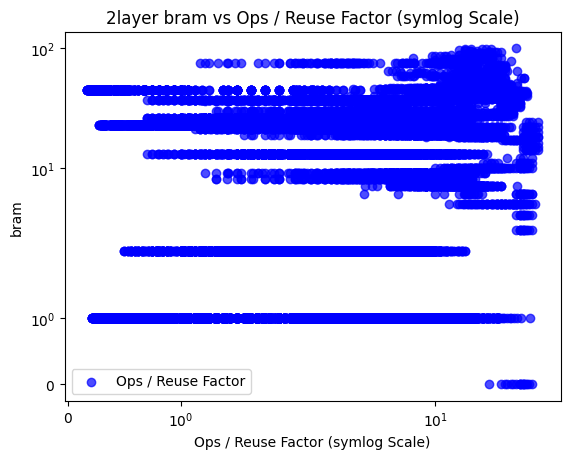

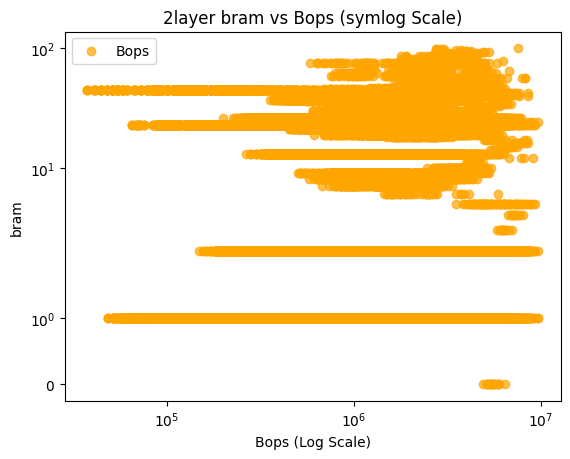

Generating scatter plots:  20%|██        | 1/5 [00:01<00:07,  1.81s/it]

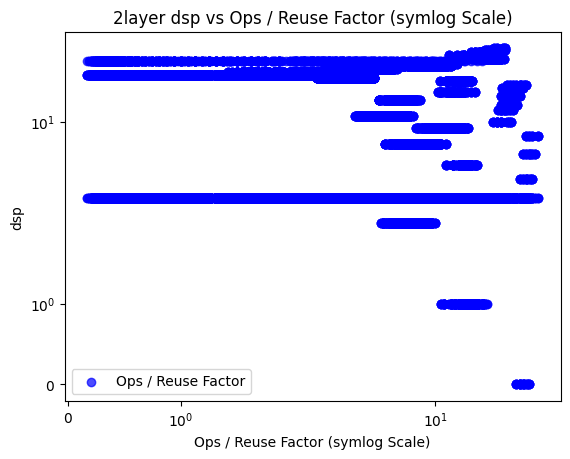

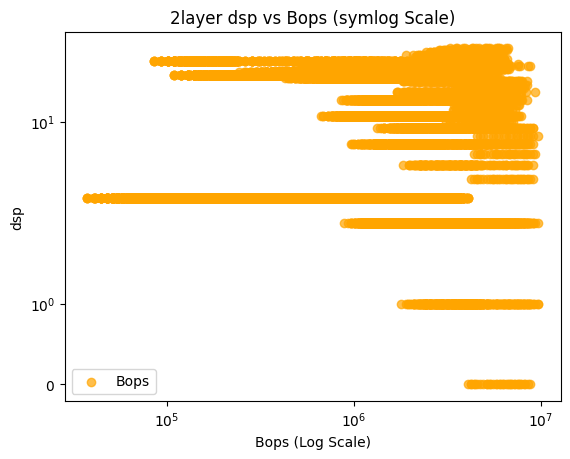

Generating scatter plots:  40%|████      | 2/5 [00:03<00:05,  1.85s/it]

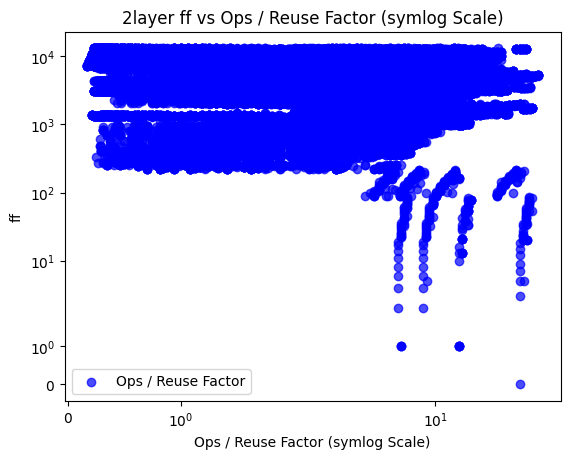

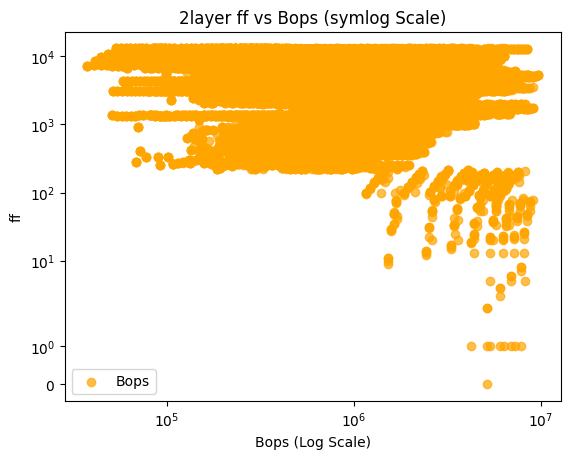

Generating scatter plots:  60%|██████    | 3/5 [00:05<00:03,  1.92s/it]

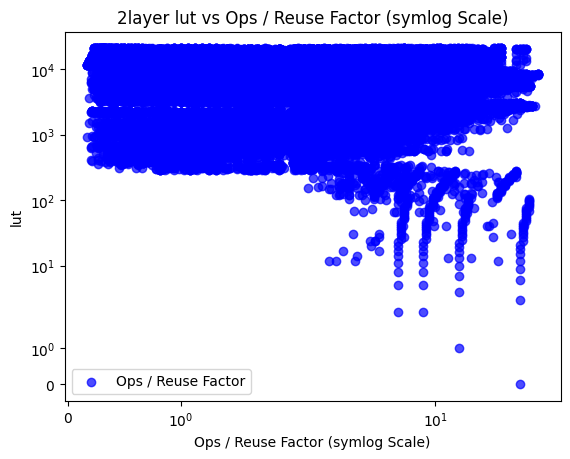

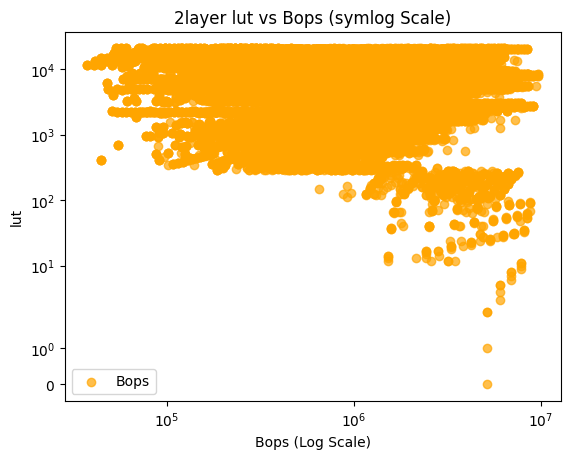

Generating scatter plots:  80%|████████  | 4/5 [00:07<00:01,  1.95s/it]

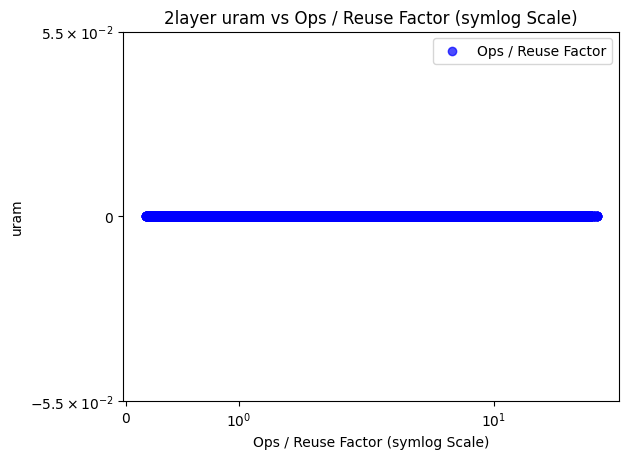

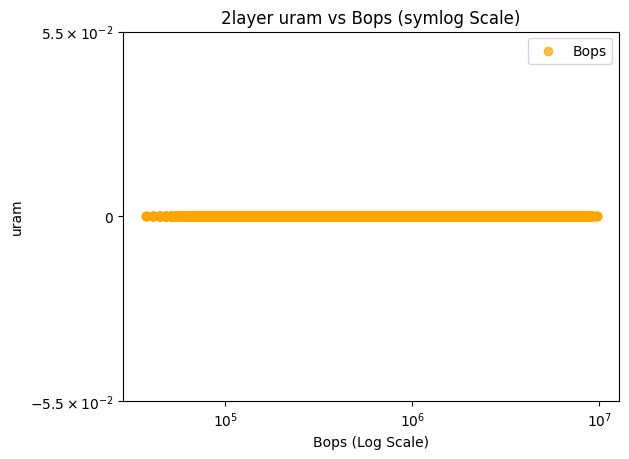

Generating scatter plots: 100%|██████████| 5/5 [00:09<00:00,  1.84s/it]


In [27]:
load_and_generate_plots(save_file="calculated_2layer_data.json", prefix="2layer")

Generating scatter plots:   0%|          | 0/5 [00:00<?, ?it/s]

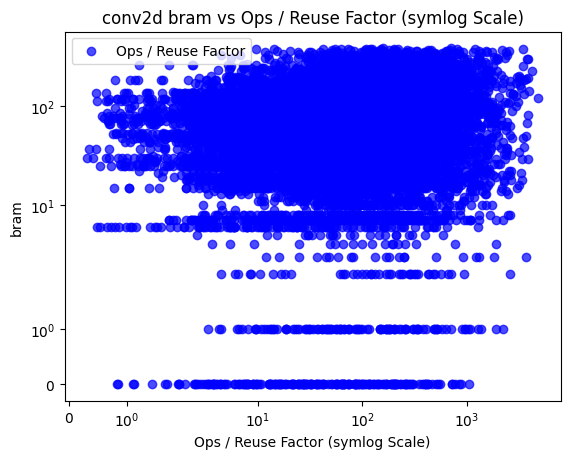

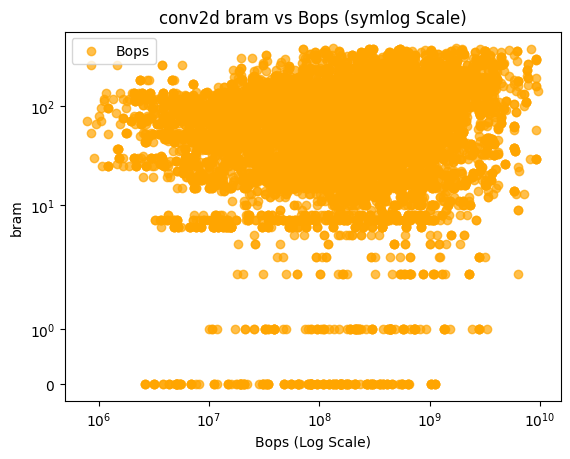

Generating scatter plots:  20%|██        | 1/5 [00:00<00:02,  1.36it/s]

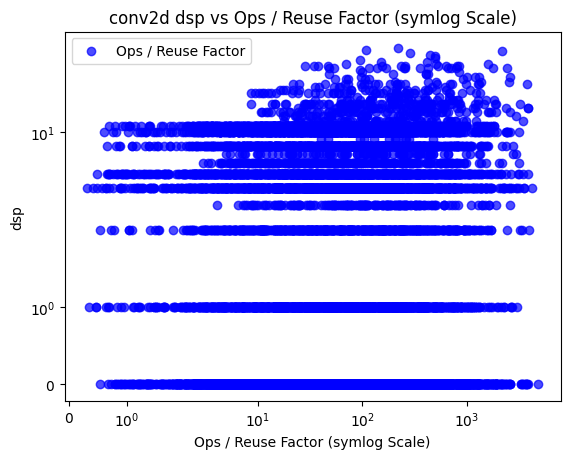

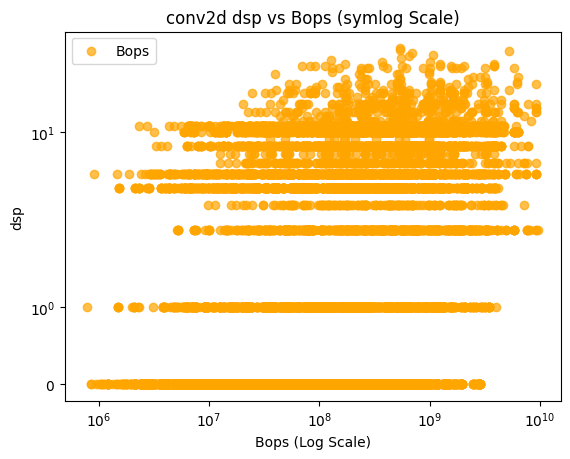

Generating scatter plots:  40%|████      | 2/5 [00:01<00:02,  1.32it/s]

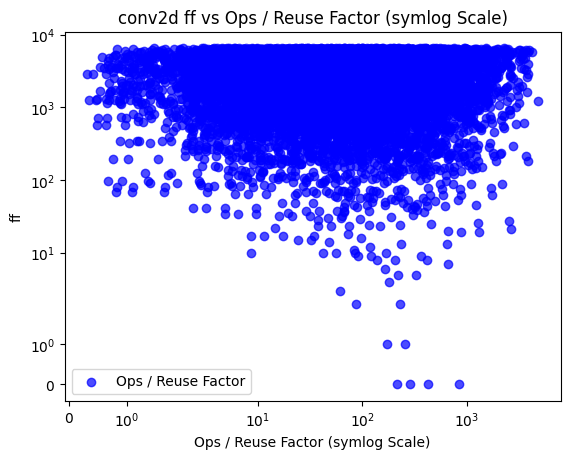

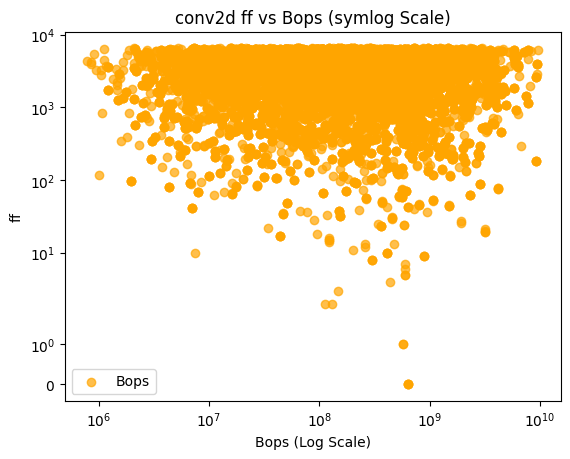

Generating scatter plots:  60%|██████    | 3/5 [00:02<00:01,  1.37it/s]

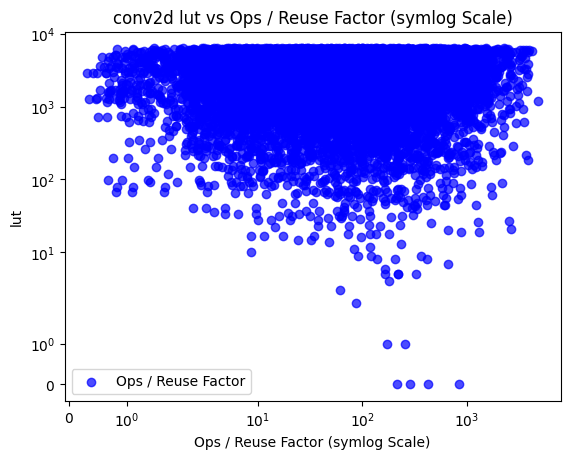

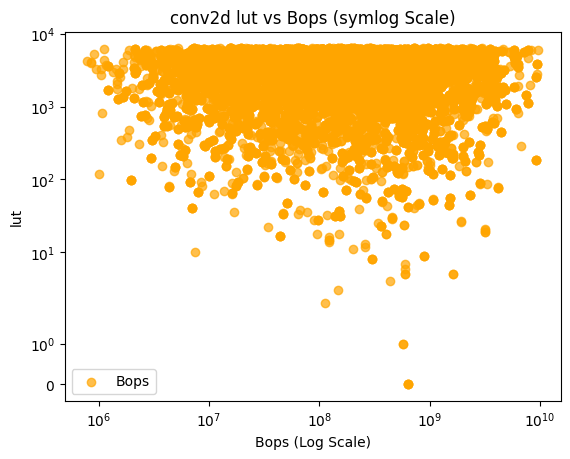

Generating scatter plots:  80%|████████  | 4/5 [00:02<00:00,  1.35it/s]

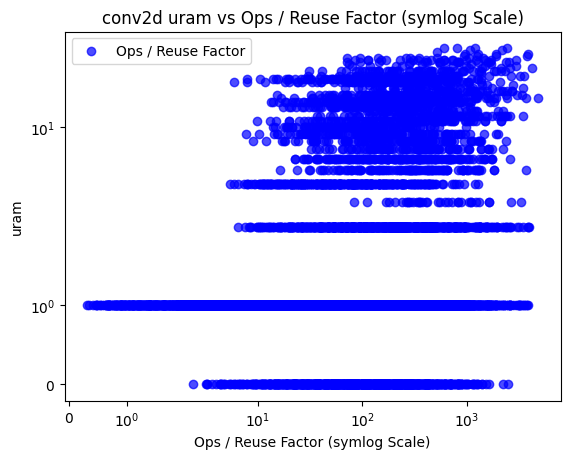

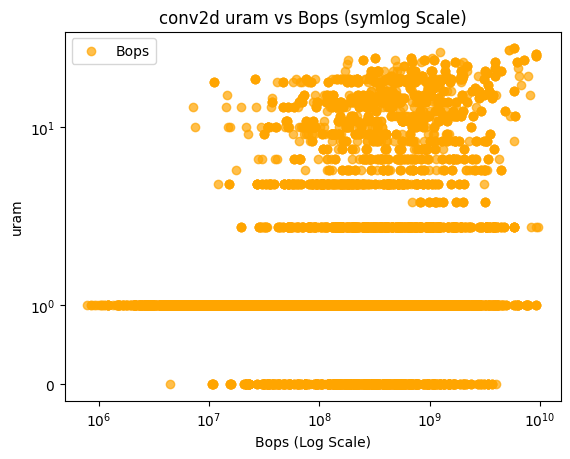

Generating scatter plots: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


In [28]:
load_and_generate_plots(save_file="calculated_conv2d_data.json", prefix="conv2d")

In [30]:
import json
import pandas as pd

def generate_heatmaps_from_file(data_file, output_prefix="heatmap"):
    """
    Generate heatmaps for resource vs bops and resource vs ops/reuse_factor, with color indicating bitwidth.

    Parameters:
        data_file (str): Path to the saved data file.
        output_prefix (str): Prefix for saving the heatmap images.
    """
    with open(data_file, "r") as f:
        resource_data = json.load(f)

    for resource, data in resource_data.items():
        # Convert data to numpy arrays
        ops = np.array(data["ops"])
        bops = np.array(data["bops"])
        values = np.array(data["values"])
        bitwidth = np.array(data["bitwidth"])
        print(resource)
        print(len(values))
        df = pd.DataFrame({"ops": ops, "bops": bops, "values": values, "bitwidth": bitwidth})
        print(df.dtypes)
        print(df.columns)
        print(df.head())
        print(df.describe())
        #print(f"Max for {resource}: {np.max(values)}")

        # Create heatmaps
        plt.figure(figsize=(10, 8))
        plt.scatter(bops, values, c=bitwidth, cmap="viridis", alpha=0.7)
        plt.colorbar(label="Bitwidth")
        plt.xscale("log")
        plt.yscale("log")
        plt.title(f"{output_prefix} {resource} vs BOPs (Color: Bitwidth)")
        plt.xlabel("BOPs (Log Scale)")
        plt.ylabel(resource)
        plt.tight_layout()
        plt.savefig(f"{output_prefix}_bops_vs_{resource}_heatmap.png")
        plt.show()

        plt.figure(figsize=(10, 8))
        plt.scatter(ops, values, c=bitwidth, cmap="viridis", alpha=0.7)
        plt.colorbar(label="Bitwidth")
        plt.xscale("log")
        plt.yscale("log")
        plt.title(f"{output_prefix} {resource} vs Ops/Reuse Factor (Color: Bitwidth)")
        plt.xlabel("Ops/Reuse Factor (Log Scale)")
        plt.ylabel(resource)
        plt.tight_layout()
        plt.savefig(f"{output_prefix}_ops_vs_{resource}_heatmap.png")
        plt.show()

bram
65309
ops         float64
bops        float64
values      float64
bitwidth      int64
dtype: object
Index(['ops', 'bops', 'values', 'bitwidth'], dtype='object')
         ops          bops  values  bitwidth
0  26.000000  5.134444e+06    61.0        10
1  13.006351  5.134444e+06     1.0        10
2   8.672313  5.134444e+06     2.0        10
3   6.504764  5.134444e+06     2.0        10
4  26.000000  6.039660e+06    76.0        12
                ops          bops        values     bitwidth
count  65309.000000  6.530900e+04  65309.000000  65309.00000
mean       4.327516  1.485377e+06      2.889410      8.98207
std        4.088020  1.269296e+06      6.169386      4.57936
min        0.172001  3.744000e+04      0.500000      2.00000
25%        1.667752  5.737645e+05      1.000000      4.00000
50%        3.001954  1.128067e+06      1.500000      8.00000
75%        5.625000  1.990047e+06      2.000000     12.00000
max       32.000000  9.666560e+06    113.000000     16.00000


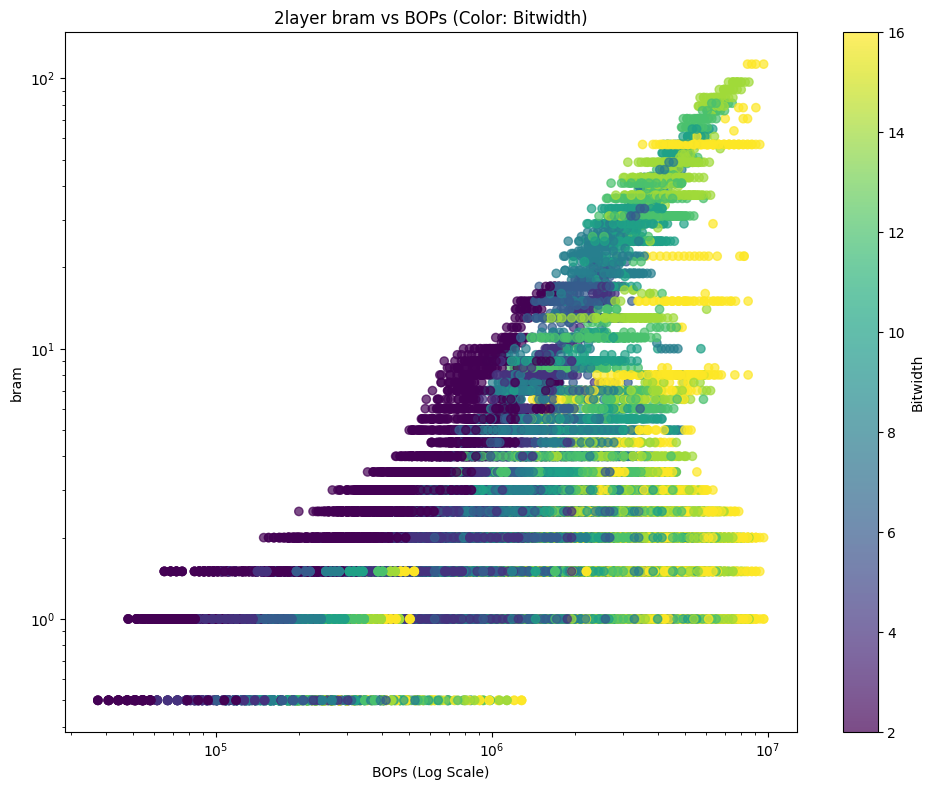

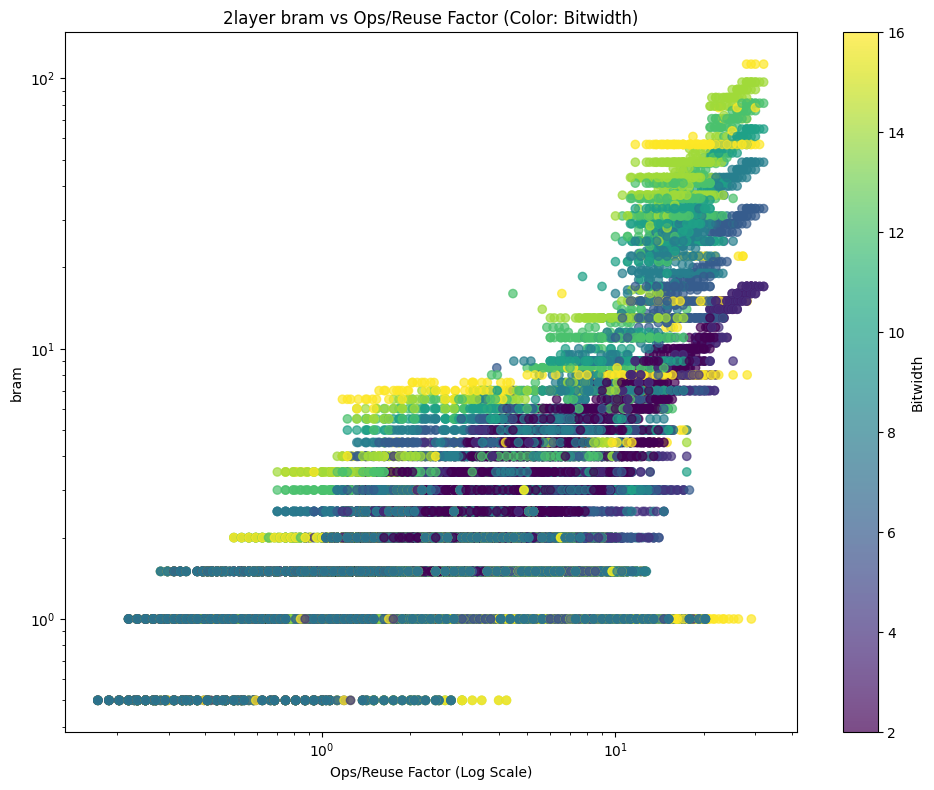

dsp
65309
ops         float64
bops        float64
values      float64
bitwidth      int64
dtype: object
Index(['ops', 'bops', 'values', 'bitwidth'], dtype='object')
         ops          bops  values  bitwidth
0  26.000000  5.134444e+06    29.0        10
1  13.006351  5.134444e+06    16.0        10
2   8.672313  5.134444e+06     8.0        10
3   6.504764  5.134444e+06     8.0        10
4  26.000000  6.039660e+06    29.0        12
                ops          bops        values     bitwidth
count  65309.000000  6.530900e+04  65309.000000  65309.00000
mean       4.327516  1.485377e+06      3.095102      8.98207
std        4.088020  1.269296e+06      4.063169      4.57936
min        0.172001  3.744000e+04      0.000000      2.00000
25%        1.667752  5.737645e+05      0.000000      4.00000
50%        3.001954  1.128067e+06      2.000000      8.00000
75%        5.625000  1.990047e+06      4.000000     12.00000
max       32.000000  9.666560e+06     32.000000     16.00000


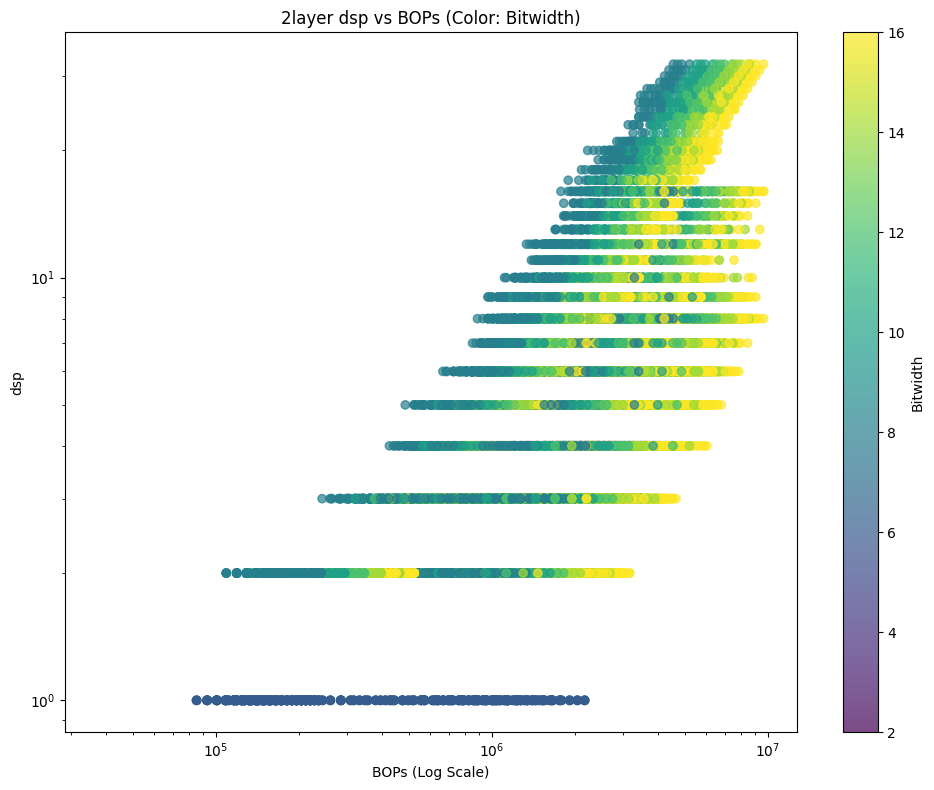

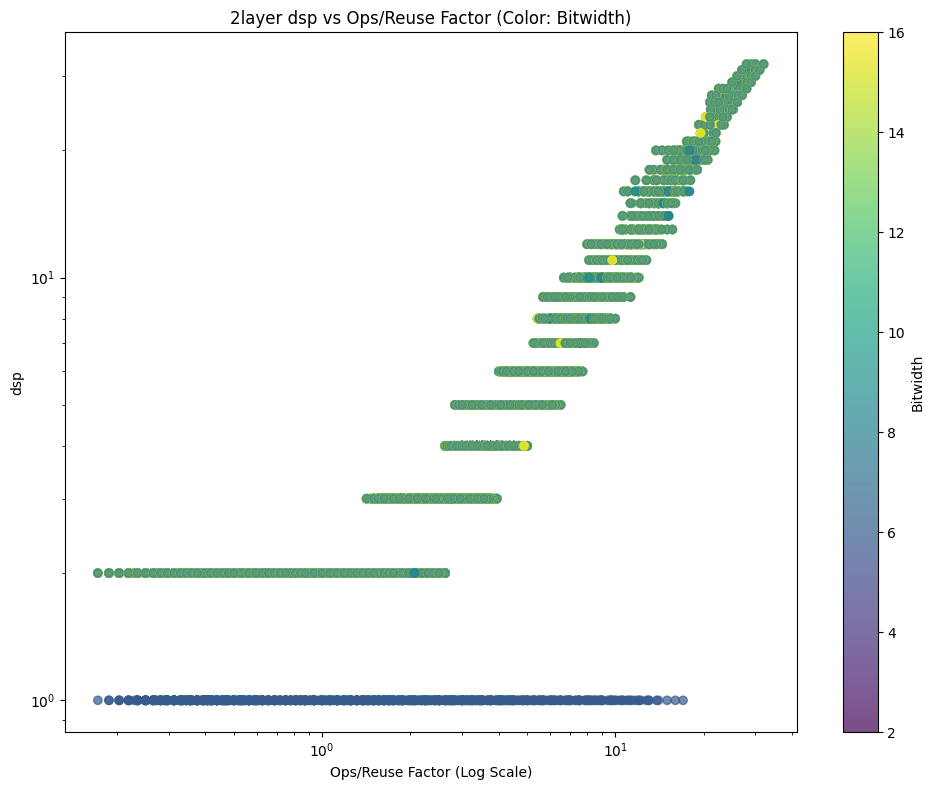

ff
65309
ops         float64
bops        float64
values      float64
bitwidth      int64
dtype: object
Index(['ops', 'bops', 'values', 'bitwidth'], dtype='object')
         ops          bops   values  bitwidth
0  26.000000  5.134444e+06  21363.0        10
1  13.006351  5.134444e+06  21371.0        10
2   8.672313  5.134444e+06  21408.0        10
3   6.504764  5.134444e+06  21408.0        10
4  26.000000  6.039660e+06  21384.0        12
                ops          bops        values     bitwidth
count  65309.000000  6.530900e+04  65309.000000  65309.00000
mean       4.327516  1.485377e+06  12160.261848      8.98207
std        4.088020  1.269296e+06   3808.675402      4.57936
min        0.172001  3.744000e+04   2820.000000      2.00000
25%        1.667752  5.737645e+05   9337.000000      4.00000
50%        3.001954  1.128067e+06  11829.000000      8.00000
75%        5.625000  1.990047e+06  14905.000000     12.00000
max       32.000000  9.666560e+06  23331.000000     16.00000


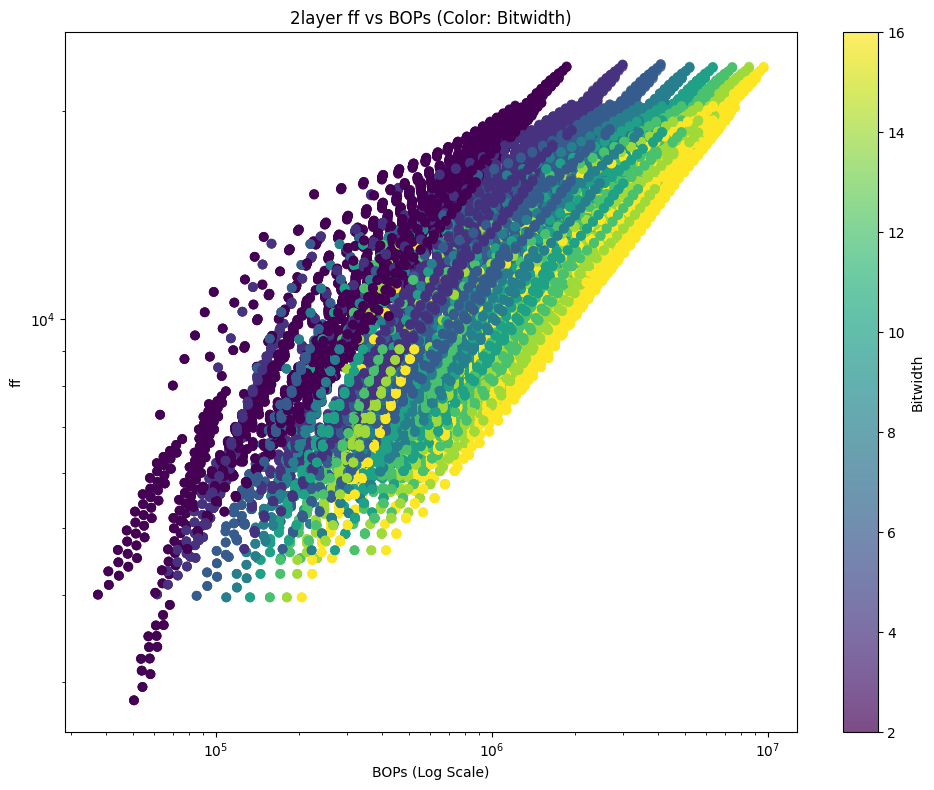

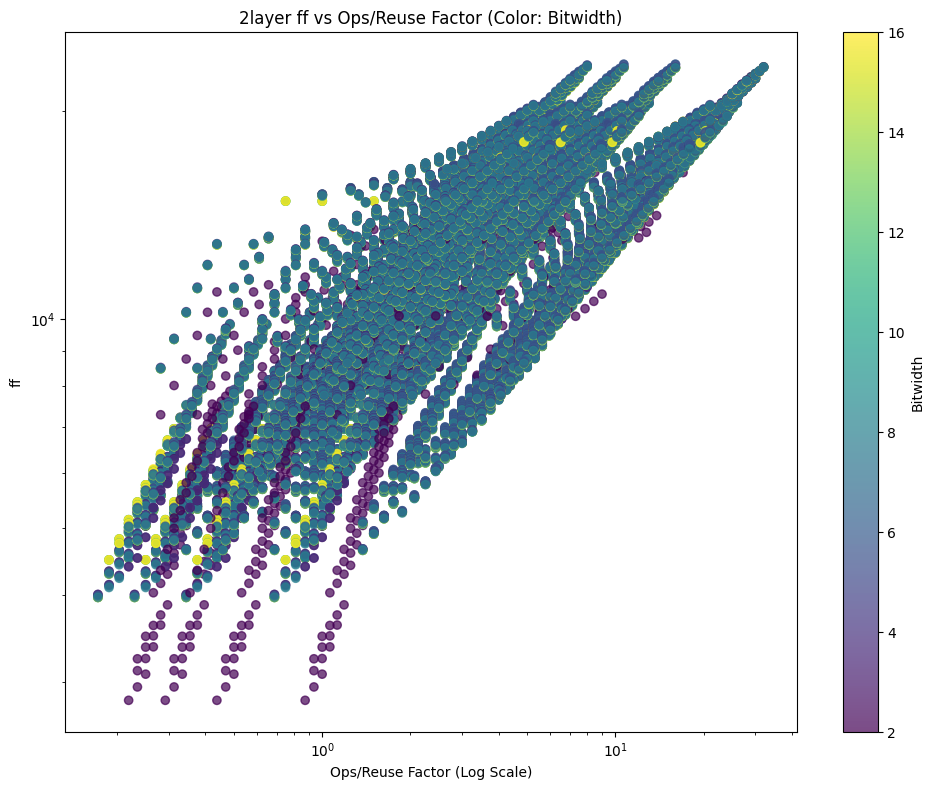

lut
65309
ops         float64
bops        float64
values      float64
bitwidth      int64
dtype: object
Index(['ops', 'bops', 'values', 'bitwidth'], dtype='object')
         ops          bops   values  bitwidth
0  26.000000  5.134444e+06  28790.0        10
1  13.006351  5.134444e+06  36030.0        10
2   8.672313  5.134444e+06  34523.0        10
3   6.504764  5.134444e+06  34523.0        10
4  26.000000  6.039660e+06  27482.0        12
                ops          bops        values     bitwidth
count  65309.000000  6.530900e+04  65309.000000  65309.00000
mean       4.327516  1.485377e+06  17390.455818      8.98207
std        4.088020  1.269296e+06   6287.279402      4.57936
min        0.172001  3.744000e+04   2972.000000      2.00000
25%        1.667752  5.737645e+05  12857.000000      4.00000
50%        3.001954  1.128067e+06  16734.000000      8.00000
75%        5.625000  1.990047e+06  21282.000000     12.00000
max       32.000000  9.666560e+06  46799.000000     16.00000


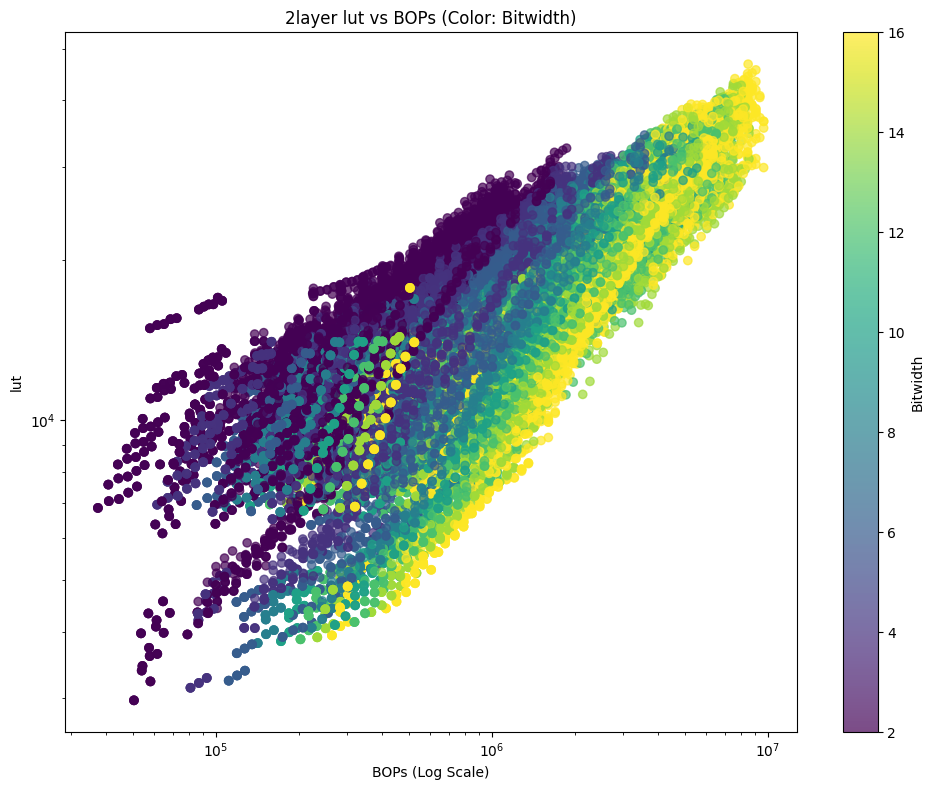

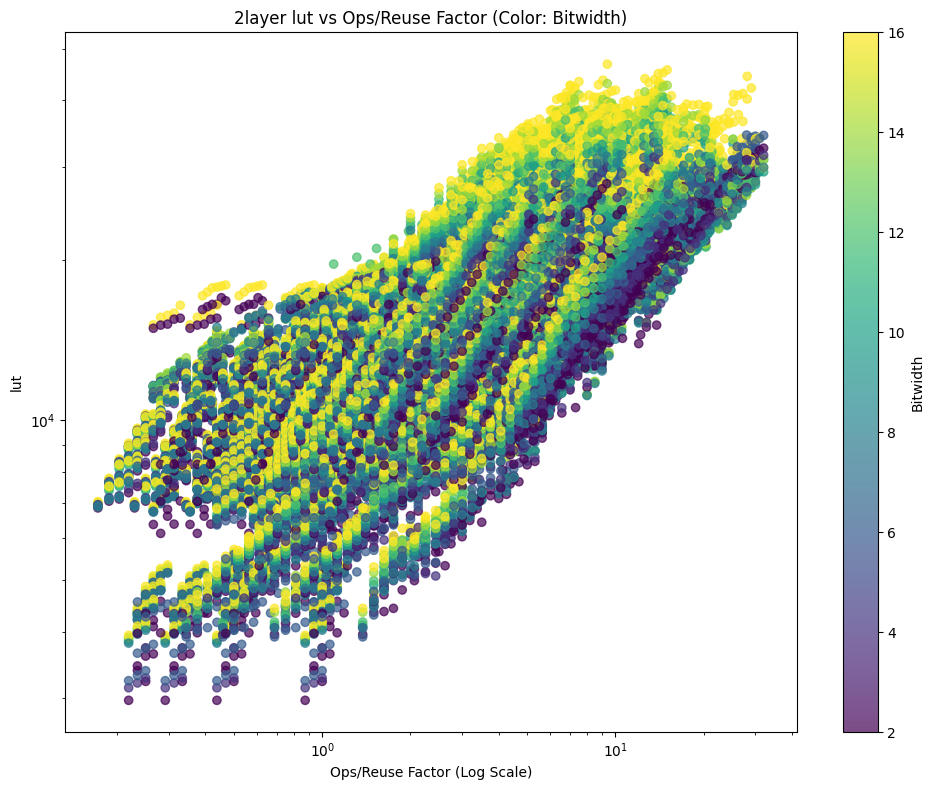

uram
65309
ops         float64
bops        float64
values      float64
bitwidth      int64
dtype: object
Index(['ops', 'bops', 'values', 'bitwidth'], dtype='object')
         ops          bops  values  bitwidth
0  26.000000  5.134444e+06     0.0        10
1  13.006351  5.134444e+06     0.0        10
2   8.672313  5.134444e+06     0.0        10
3   6.504764  5.134444e+06     0.0        10
4  26.000000  6.039660e+06     0.0        12
                ops          bops   values     bitwidth
count  65309.000000  6.530900e+04  65309.0  65309.00000
mean       4.327516  1.485377e+06      0.0      8.98207
std        4.088020  1.269296e+06      0.0      4.57936
min        0.172001  3.744000e+04      0.0      2.00000
25%        1.667752  5.737645e+05      0.0      4.00000
50%        3.001954  1.128067e+06      0.0      8.00000
75%        5.625000  1.990047e+06      0.0     12.00000
max       32.000000  9.666560e+06      0.0     16.00000


/tmp/ipykernel_191028/724401821.py:35: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


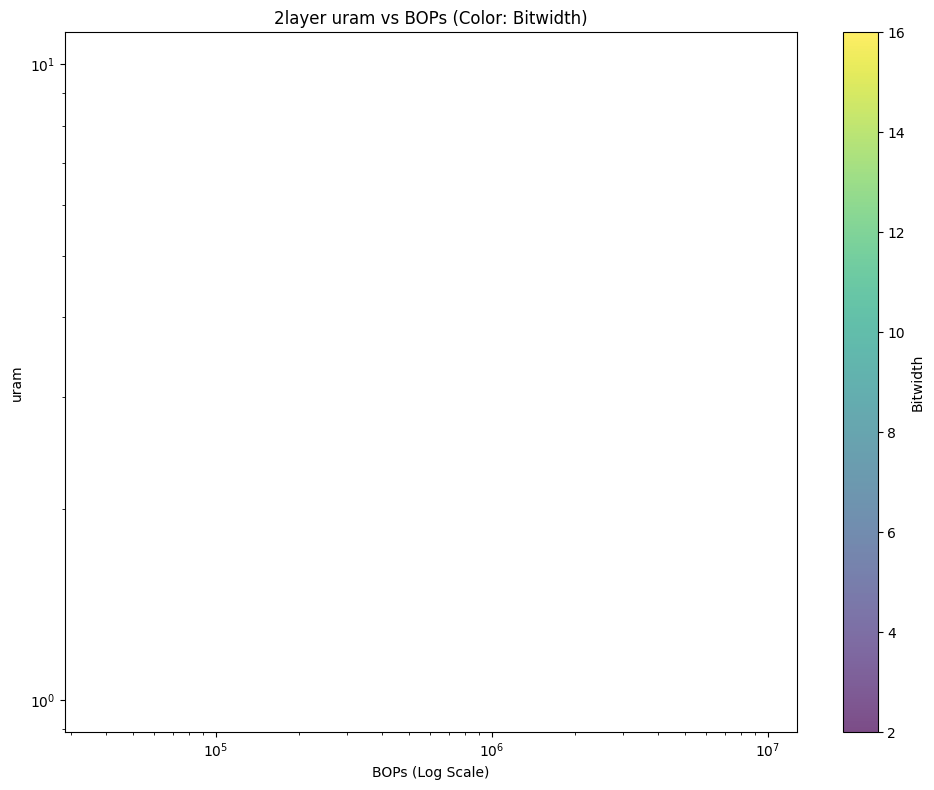

/tmp/ipykernel_191028/724401821.py:47: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


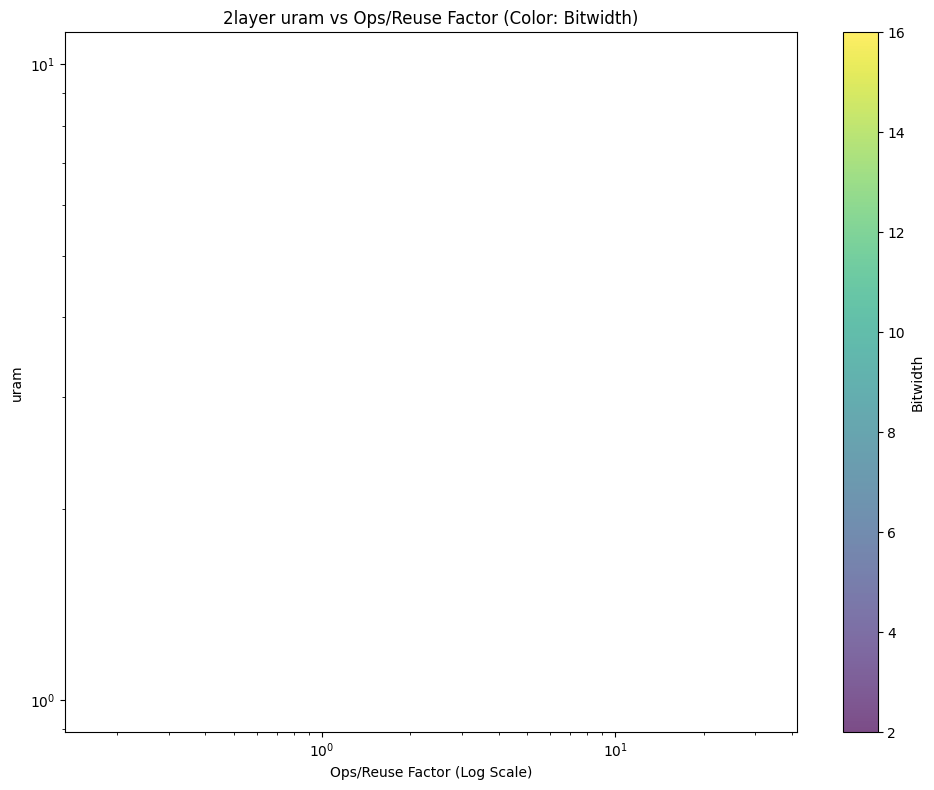

In [31]:
generate_heatmaps_from_file("calculated_2layer_data.json", output_prefix="2layer")

bram
12487
ops         float64
bops        float64
values      float64
bitwidth      int64
dtype: object
Index(['ops', 'bops', 'values', 'bitwidth'], dtype='object')
          ops          bops  values  bitwidth
0  426.087530  6.427226e+08    11.0         4
1  284.064133  6.427226e+08    11.0         4
2  213.050267  6.427226e+08    11.0         4
3  852.123047  6.427226e+08    11.0         4
4  256.789111  5.713366e+08    32.0         8
                ops          bops        values      bitwidth
count  12487.000000  1.248700e+04  12487.000000  12487.000000
mean     190.709024  4.872724e+08     35.393850      9.320093
std      355.114485  8.798521e+08     42.929449      4.988402
min        0.319854  7.861446e+05      2.000000      4.000000
25%       18.594885  4.744560e+07     15.000000      4.000000
50%       67.049014  1.738082e+08     25.000000      8.000000
75%      205.289671  5.358431e+08     40.000000     16.000000
max     4819.500000  9.630113e+09   1029.500000     16.000000


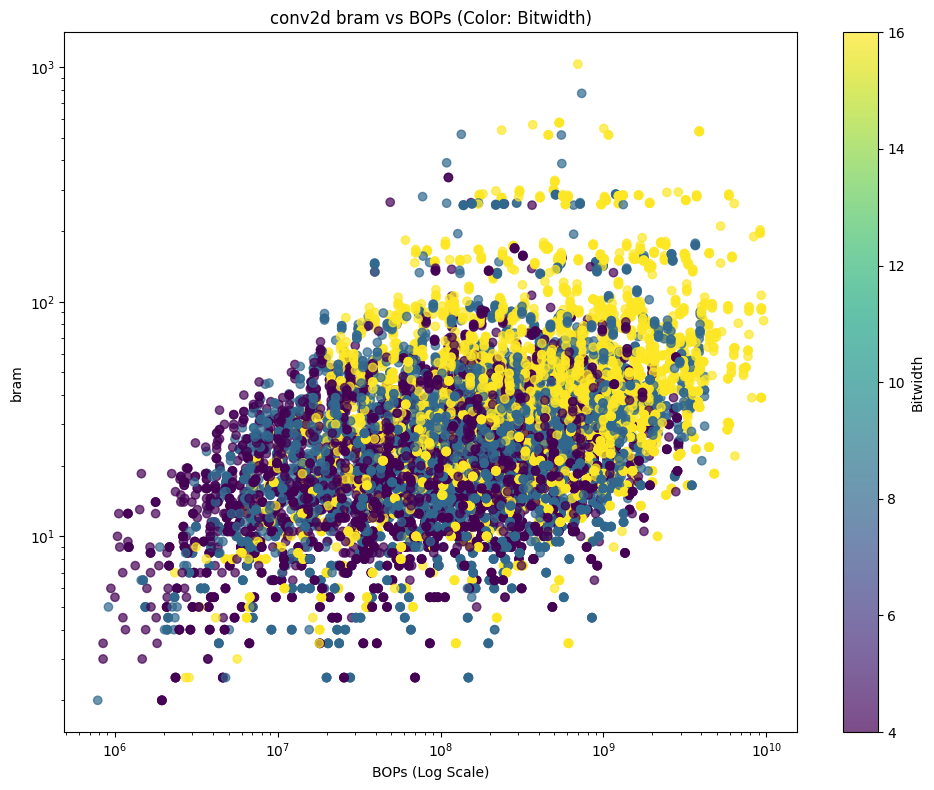

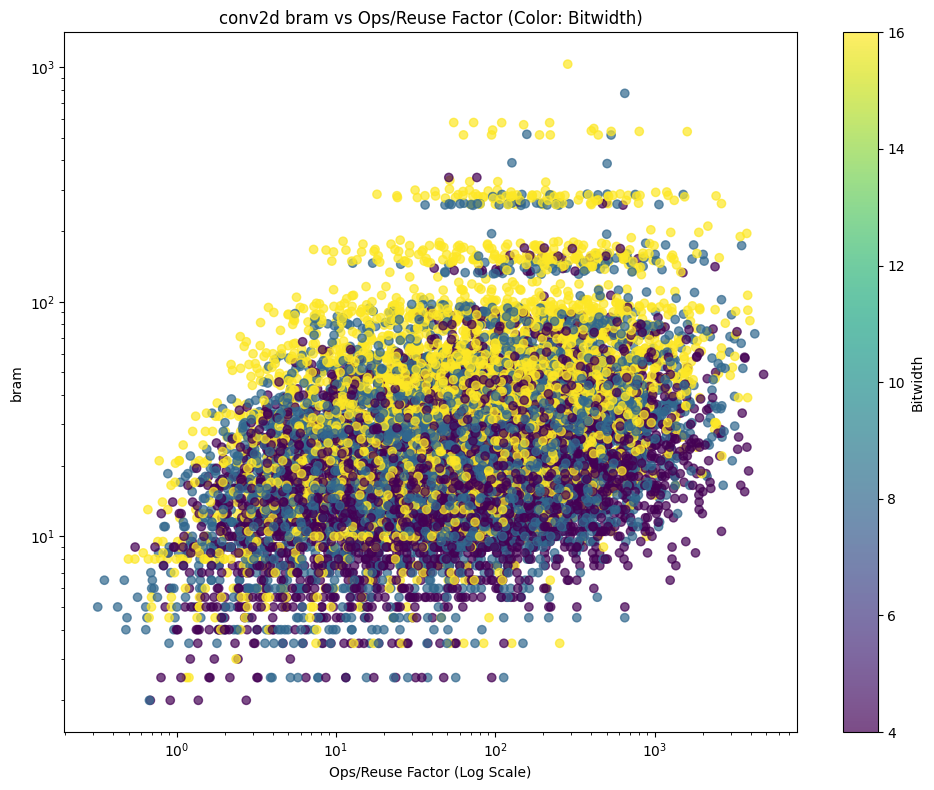

dsp
12487
ops         float64
bops        float64
values      float64
bitwidth      int64
dtype: object
Index(['ops', 'bops', 'values', 'bitwidth'], dtype='object')
          ops          bops  values  bitwidth
0  426.087530  6.427226e+08     0.0         4
1  284.064133  6.427226e+08     0.0         4
2  213.050267  6.427226e+08     0.0         4
3  852.123047  6.427226e+08     0.0         4
4  256.789111  5.713366e+08     2.0         8
                ops          bops        values      bitwidth
count  12487.000000  1.248700e+04  12487.000000  12487.000000
mean     190.709024  4.872724e+08      3.254665      9.320093
std      355.114485  8.798521e+08      6.342285      4.988402
min        0.319854  7.861446e+05      0.000000      4.000000
25%       18.594885  4.744560e+07      0.000000      4.000000
50%       67.049014  1.738082e+08      2.000000      8.000000
75%      205.289671  5.358431e+08      5.000000     16.000000
max     4819.500000  9.630113e+09    259.000000     16.000000


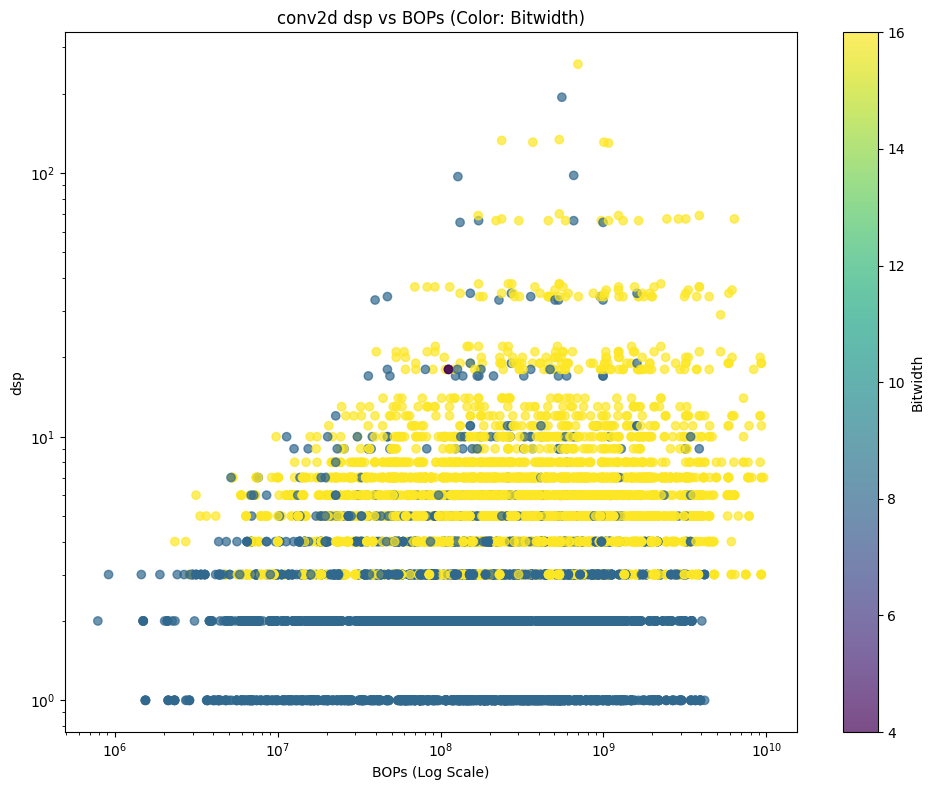

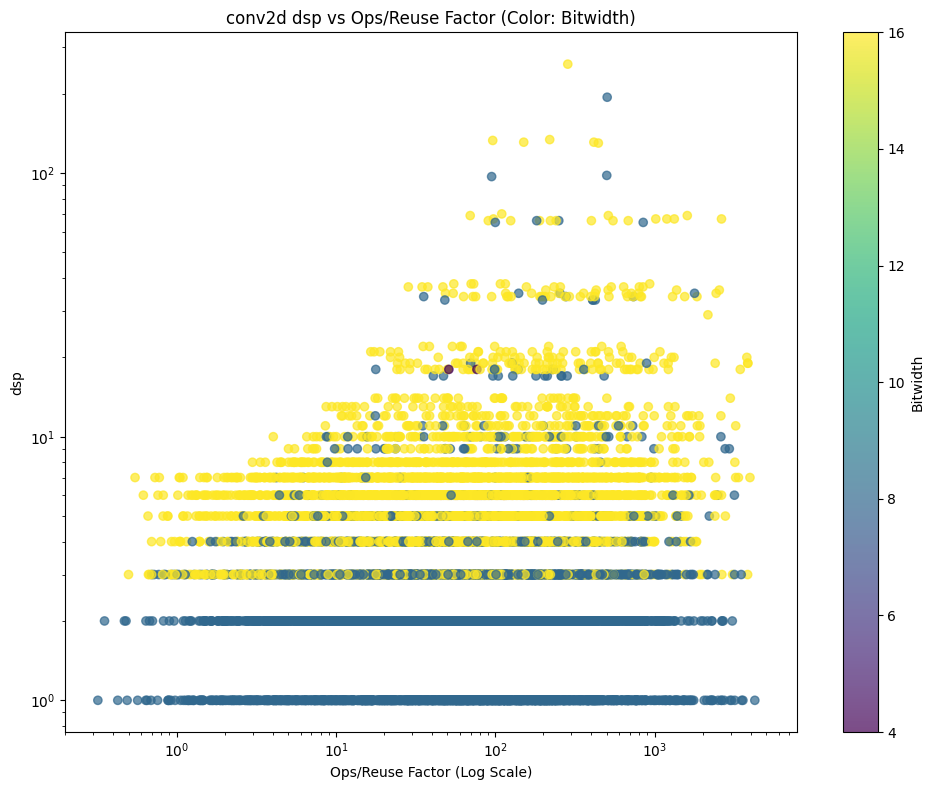

ff
12487
ops         float64
bops        float64
values      float64
bitwidth      int64
dtype: object
Index(['ops', 'bops', 'values', 'bitwidth'], dtype='object')
          ops          bops   values  bitwidth
0  426.087530  6.427226e+08  32746.0         4
1  284.064133  6.427226e+08  32746.0         4
2  213.050267  6.427226e+08  32746.0         4
3  852.123047  6.427226e+08  32746.0         4
4  256.789111  5.713366e+08  52265.0         8
                ops          bops        values      bitwidth
count  12487.000000  1.248700e+04  1.248700e+04  12487.000000
mean     190.709024  4.872724e+08  6.840141e+04      9.320093
std      355.114485  8.798521e+08  8.424129e+04      4.988402
min        0.319854  7.861446e+05  5.829000e+03      4.000000
25%       18.594885  4.744560e+07  3.466250e+04      4.000000
50%       67.049014  1.738082e+08  4.998000e+04      8.000000
75%      205.289671  5.358431e+08  7.111850e+04     16.000000
max     4819.500000  9.630113e+09  1.570553e+06     16.000

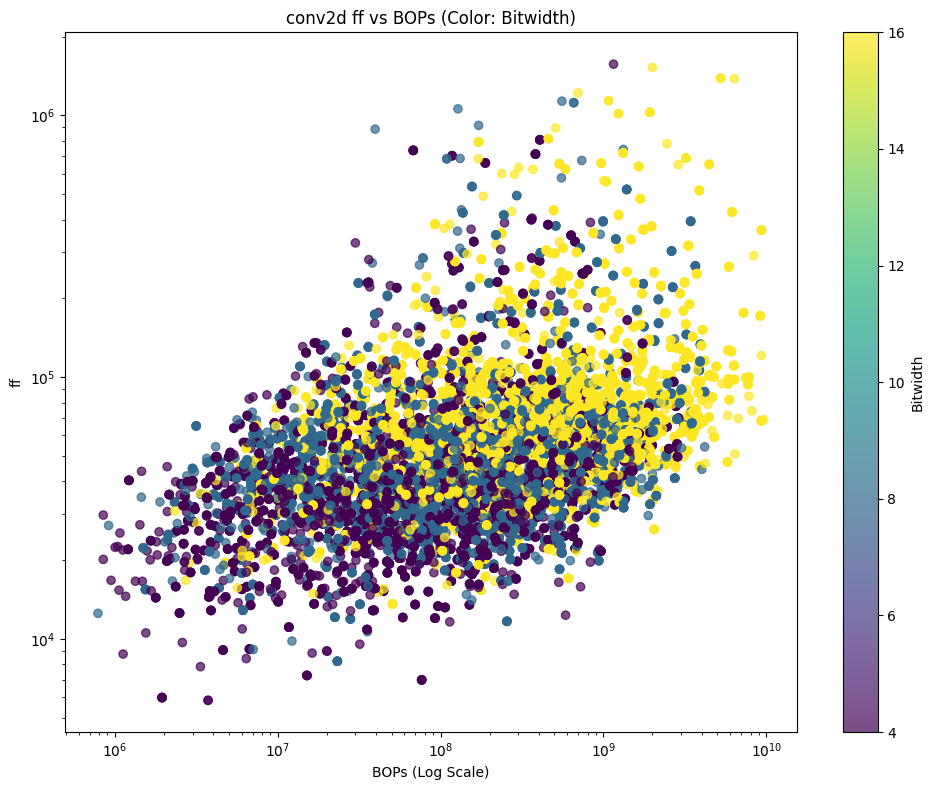

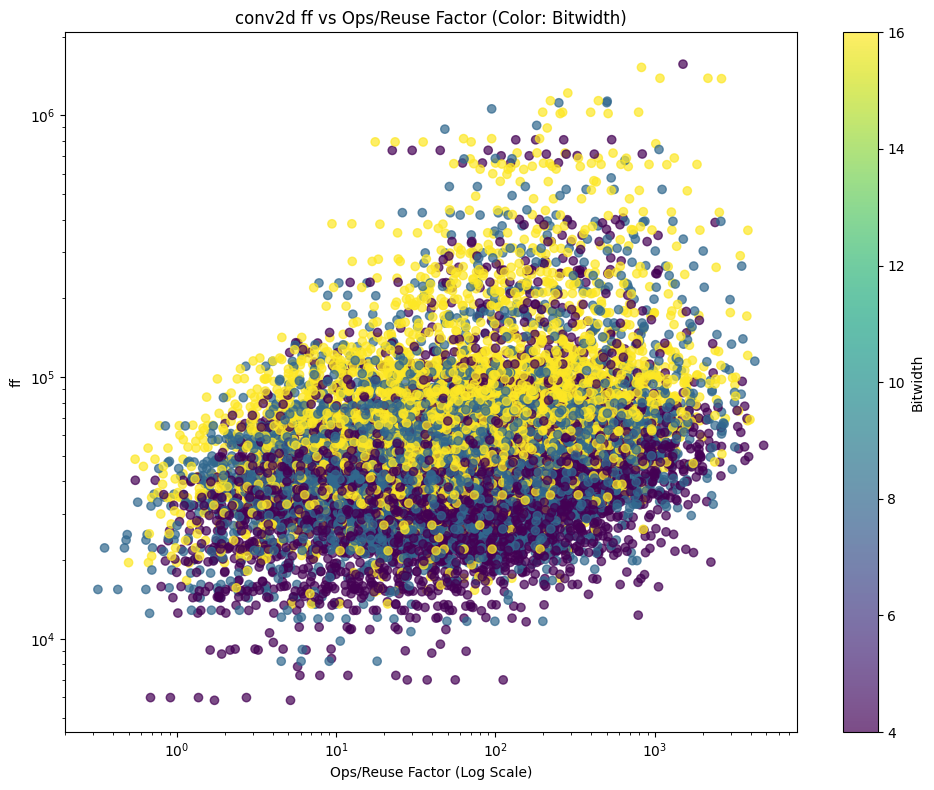

lut
12487
ops         float64
bops        float64
values      float64
bitwidth      int64
dtype: object
Index(['ops', 'bops', 'values', 'bitwidth'], dtype='object')
          ops          bops   values  bitwidth
0  426.087530  6.427226e+08  16973.0         4
1  284.064133  6.427226e+08  16973.0         4
2  213.050267  6.427226e+08  16973.0         4
3  852.123047  6.427226e+08  16973.0         4
4  256.789111  5.713366e+08  21217.0         8
                ops          bops         values      bitwidth
count  12487.000000  1.248700e+04   12487.000000  12487.000000
mean     190.709024  4.872724e+08   32526.869304      9.320093
std      355.114485  8.798521e+08   24940.585507      4.988402
min        0.319854  7.861446e+05    3821.000000      4.000000
25%       18.594885  4.744560e+07   19446.000000      4.000000
50%       67.049014  1.738082e+08   27215.000000      8.000000
75%      205.289671  5.358431e+08   38216.000000     16.000000
max     4819.500000  9.630113e+09  476065.000000 

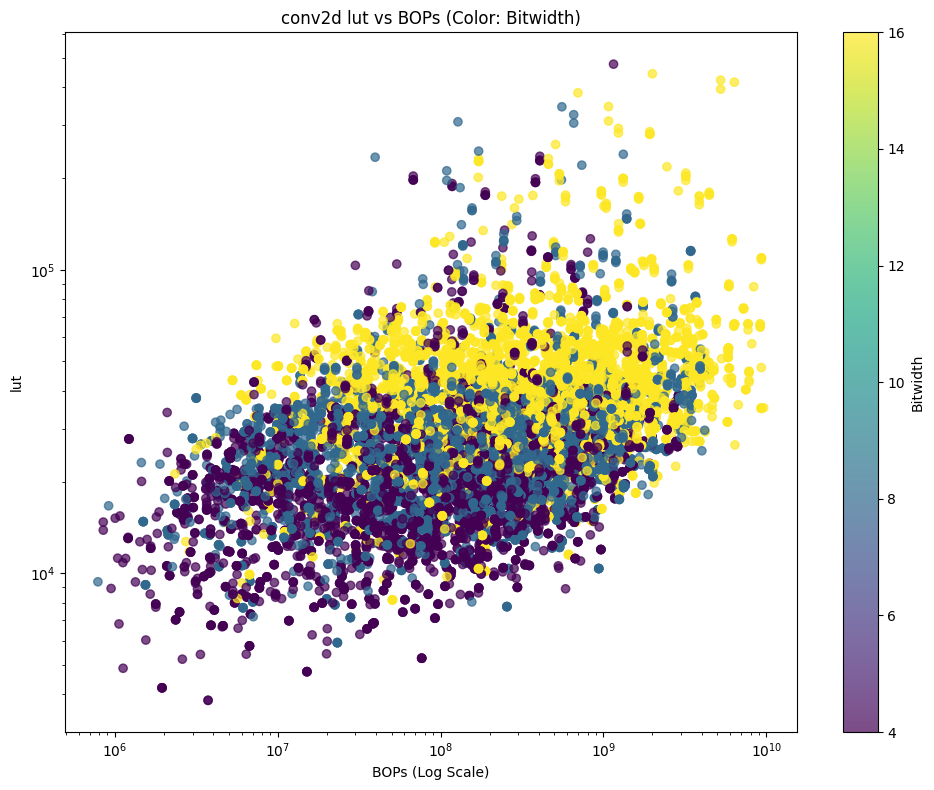

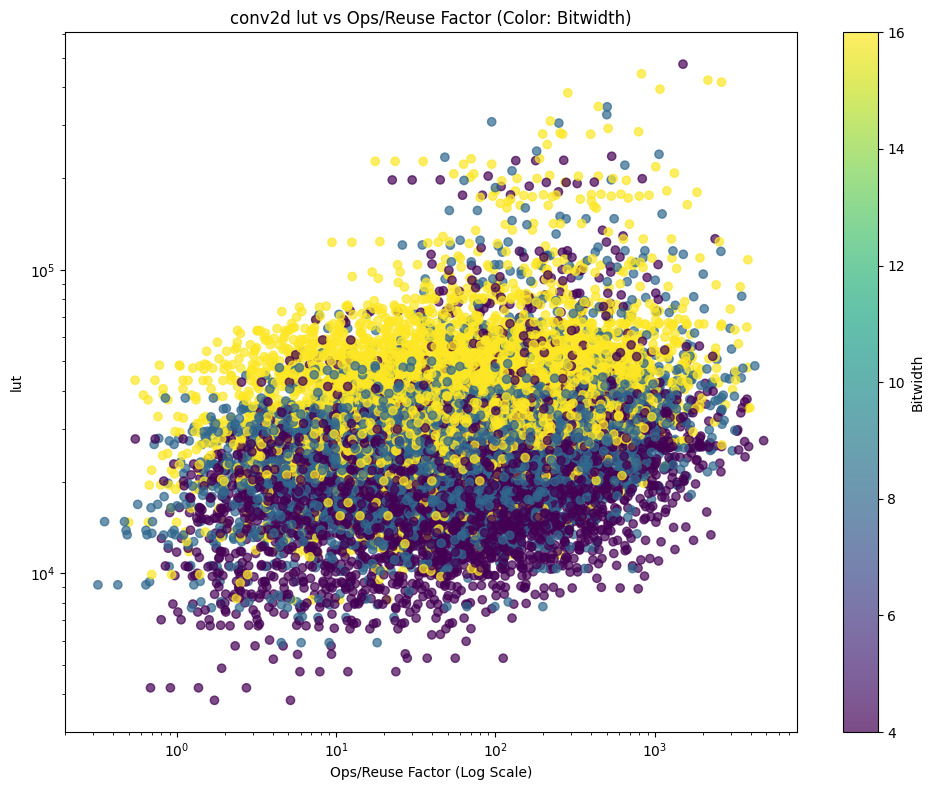

uram
12487
ops         float64
bops        float64
values      float64
bitwidth      int64
dtype: object
Index(['ops', 'bops', 'values', 'bitwidth'], dtype='object')
          ops          bops  values  bitwidth
0  426.087530  6.427226e+08     2.0         4
1  284.064133  6.427226e+08     2.0         4
2  213.050267  6.427226e+08     2.0         4
3  852.123047  6.427226e+08     2.0         4
4  256.789111  5.713366e+08     0.0         8
                ops          bops        values      bitwidth
count  12487.000000  1.248700e+04  12487.000000  12487.000000
mean     190.709024  4.872724e+08      2.317770      9.320093
std      355.114485  8.798521e+08      5.117043      4.988402
min        0.319854  7.861446e+05      0.000000      4.000000
25%       18.594885  4.744560e+07      0.000000      4.000000
50%       67.049014  1.738082e+08      0.000000      8.000000
75%      205.289671  5.358431e+08      2.000000     16.000000
max     4819.500000  9.630113e+09     63.000000     16.000000


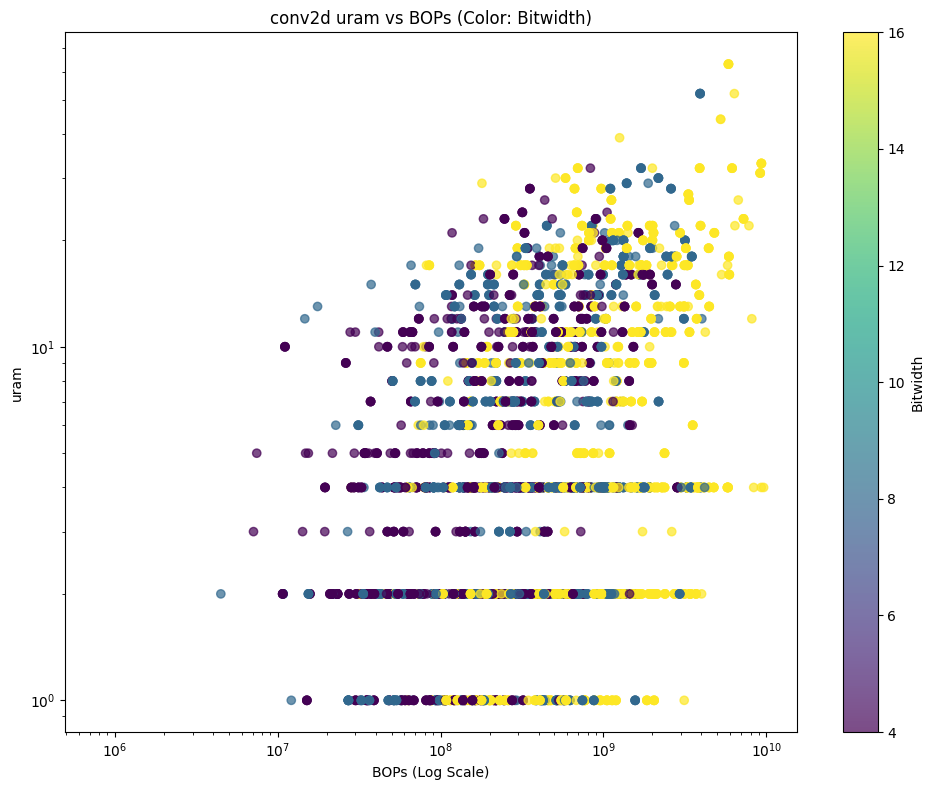

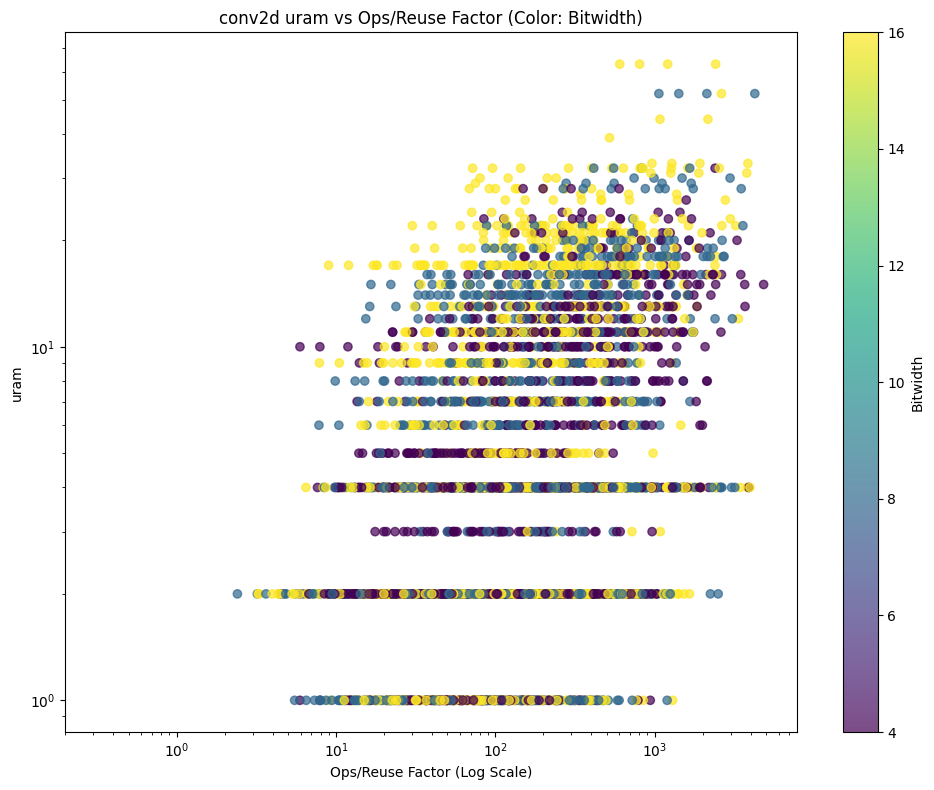

In [40]:
generate_heatmaps_from_file("calculated_conv2d_data.json", output_prefix="conv2d")